# **CRAB Quickstart**

Goal: run a single CRAB optimization using the refactored `src/` workflows starting from the default baseline pulses.
Quickstart: edit the Parameter Panel, run all cells, then review the Results Summary.

Sections:
- [Parameter Panel](#Parameter-Panel)
- [Run Experiment](#Run-Experiment)
- [Standard Plots](#Standard-Plots)
- [Penalty History](#Penalty-History)
- [Results Summary](#Results-Summary)
- [Troubleshooting](#Troubleshooting)


## Imports


In [2]:
# Imports
from pathlib import Path
import json
import numpy as np

# Notebook bootstrap: make repo root importable and set CWD to it
import os, sys
repo_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path().resolve()
# If you're inside notebooks/, go one up; otherwise keep current
if (repo_root / "src").is_dir() and (repo_root / "notebooks").is_dir():
    pass
elif (repo_root.parent / "src").is_dir():
    repo_root = repo_root.parent
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print("Repo root:", repo_root)


from src import (
    ExperimentConfig,
    override_from_dict,
    run_experiment,
    plot_cost_history,
    plot_pulses,
    plot_summary,
    plot_penalties_history,
    Result,
)


Repo root: C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB


C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\src\plotting.py:134: SyntaxWarning: invalid escape sequence '\m'
  ax_delta.set_xlabel("Time ($\mu$s)")


## Parameter Panel


In [9]:
# @title Parameter Panel
BASELINE_ARRAYS = Path('data/baselines/_baseline_crab/arrays.npz')
with np.load(BASELINE_ARRAYS) as baseline_npz:
    arrays = {key: np.array(baseline_npz[key]) for key in baseline_npz.files}

t_us = arrays['t'].astype(float)
T_US = float(arrays['T'])
M = int(arrays['Nt'])
delta0 = arrays['Delta0'].astype(float)
delta_max_rad_per_us = float(np.abs(delta0).max())
delta_max_MHz = delta_max_rad_per_us / (2 * np.pi)
default_K = int(arrays['CRAB_BASIS_OMEGA'].shape[1])
default_omegas = (np.pi / T_US * np.arange(1, default_K + 1)).tolist()

user_params = {
    'run_name': None,
    'output_dir': 'results/quickstart',
    'objective': 'terminal',
    'time_grid': {'t0_us': float(t_us[0]), 't1_us': float(t_us[-1]), 'M': M},
    'crab': {
        'K': default_K,
        'omegas_rad_per_us': default_omegas,
        'phases': [0.0] * default_K,
        'use_delta': True,
    },
    'weights': {'w_power': 1.0e-4, 'w_neg': 1.0, 'neg_kappa': 10.0},
    'optimizer': {
        'method': 'adam',
        'max_iters': 2000,
        'learning_rate': 0.05,
        'beta1': 0.9,
        'beta2': 0.999,
        'epsilon': 1e-8,
        'grad_clip': None,
    },
    'path': {'reference': 'adiabatic_ground_state'},
    'ensemble': {
        'beta_min': 0.9,
        'beta_max': 1.1,
        'num_beta': 5,
        'detuning_MHz_min': -0.1*delta_max_MHz,
        'detuning_MHz_max': 0.1*delta_max_MHz,
        'num_detuning': 5,
    },
}

overrides = {
    'baseline': {'name': 'default'},
    'run_name': user_params['run_name'],
    'artifacts_root': str(Path(user_params['output_dir']).resolve()),
    'optimizer_options': {
        'method': user_params['optimizer']['method'],
        'max_iters': int(user_params['optimizer']['max_iters']),
        'learning_rate': float(user_params['optimizer']['learning_rate']),
        'beta1': float(user_params['optimizer']['beta1']),
        'beta2': float(user_params['optimizer']['beta2']),
        'epsilon': float(user_params['optimizer']['epsilon']),
        'grad_clip': user_params['optimizer']['grad_clip'],
        'optimize_delta': bool(user_params['crab']['use_delta']),
        'K': int(user_params['crab']['K']),
        'omegas_rad_per_us': user_params['crab']['omegas_rad_per_us'],
        'phases': user_params['crab']['phases'],
    },
    'penalties': {
        'power_weight': float(user_params['weights']['w_power']),
        'neg_weight': float(user_params['weights']['w_neg']),
        'neg_kappa': float(user_params['weights']['neg_kappa']),
    },
    'metadata': {
        'objective': user_params['objective'],
        'path_params': user_params['path'],
        'ensemble_params': user_params['ensemble'],
    },
}

cfg = override_from_dict(ExperimentConfig(), overrides)
cfg.metadata.setdefault('baseline_arrays', str(BASELINE_ARRAYS))
cfg.metadata['delta_max_rad_per_us'] = delta_max_rad_per_us

print('Parameter summary:')
summary_rows = [
    ('objective', user_params['objective']),
    ('method', user_params['optimizer']['method']),
    ('max_iters', user_params['optimizer']['max_iters']),
    ('learning_rate', user_params['optimizer']['learning_rate']),
    ('grad_clip', user_params['optimizer']['grad_clip']),
    ('K', user_params['crab']['K']),
    ('use_delta', user_params['crab']['use_delta']),
    ('w_power', user_params['weights']['w_power']),
    ('w_neg', user_params['weights']['w_neg']),
]
for name, value in summary_rows:
    print(f"  {name:>15}: {value}")

print(json.dumps(cfg.to_dict(), indent=2))
cfg


Parameter summary:
        objective: terminal
           method: adam
        max_iters: 2000
    learning_rate: 0.05
        grad_clip: None
                K: 4
        use_delta: True
          w_power: 0.0001
            w_neg: 1.0
{
  "baseline": {
    "name": "default",
    "path": null
  },
  "run_name": null,
  "artifacts_root": "C:\\Users\\yehon\\Dropbox\\Thesis\\Projects\\GRAPE + CRAB\\results\\quickstart",
  "random_seed": null,
  "optimizer_options": {
    "method": "adam",
    "max_iters": 2000,
    "learning_rate": 0.05,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-08,
    "grad_clip": null,
    "optimize_delta": true,
    "K": 4,
    "omegas_rad_per_us": [
      31.41592653589793,
      62.83185307179586,
      94.24777960769379,
      125.66370614359172
    ],
    "phases": [
      0.0,
      0.0,
      0.0,
      0.0
    ]
  },
  "penalties": {
    "power_weight": 0.0001,
    "neg_weight": 1.0,
    "neg_kappa": 10.0
  },
  "metadata": {
    "objective": "te

ExperimentConfig(baseline=BaselineSpec(name='default', path=None), run_name=None, artifacts_root=WindowsPath('C:/Users/yehon/Dropbox/Thesis/Projects/GRAPE + CRAB/results/quickstart'), random_seed=None, optimizer_options={'method': 'adam', 'max_iters': 2000, 'learning_rate': 0.05, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'grad_clip': None, 'optimize_delta': True, 'K': 4, 'omegas_rad_per_us': [31.41592653589793, 62.83185307179586, 94.24777960769379, 125.66370614359172], 'phases': [0.0, 0.0, 0.0, 0.0]}, penalties=PenaltyConfig(power_weight=0.0001, neg_weight=1.0, neg_kappa=10.0), metadata={'objective': 'terminal', 'path_params': {'reference': 'adiabatic_ground_state'}, 'ensemble_params': {'beta_min': 0.9, 'beta_max': 1.1, 'num_beta': 5, 'detuning_MHz_min': -2.91666667659119, 'detuning_MHz_max': 2.91666667659119, 'num_detuning': 5}, 'baseline_arrays': 'data\\baselines\\_baseline_crab\\arrays.npz', 'delta_max_rad_per_us': 183.25957208298078}, notes=None)

## Run Experiment


In [10]:
# @title Run Experiment {display-mode: "code"}
result: Result = run_experiment(cfg, method=user_params['optimizer']['method'])
result


Result(run_name='adam-default-20250922-113937', artifacts_dir=WindowsPath('C:/Users/yehon/Dropbox/Thesis/Projects/GRAPE + CRAB/results/quickstart/adam-default-20250922-113937'), config=ExperimentConfig(baseline=BaselineSpec(name='default', path=None), run_name=None, artifacts_root=WindowsPath('C:/Users/yehon/Dropbox/Thesis/Projects/GRAPE + CRAB/results/quickstart'), random_seed=None, optimizer_options={'method': 'adam', 'max_iters': 2000, 'learning_rate': 0.05, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08, 'grad_clip': None, 'optimize_delta': True, 'K': 4, 'omegas_rad_per_us': [31.41592653589793, 62.83185307179586, 94.24777960769379, 125.66370614359172], 'phases': [0.0, 0.0, 0.0, 0.0]}, penalties=PenaltyConfig(power_weight=0.0001, neg_weight=1.0, neg_kappa=10.0), metadata={'objective': 'terminal', 'path_params': {'reference': 'adiabatic_ground_state'}, 'ensemble_params': {'beta_min': 0.9, 'beta_max': 1.1, 'num_beta': 5, 'detuning_MHz_min': -2.91666667659119, 'detuning_MHz_max': 2.916

## Standard Plots


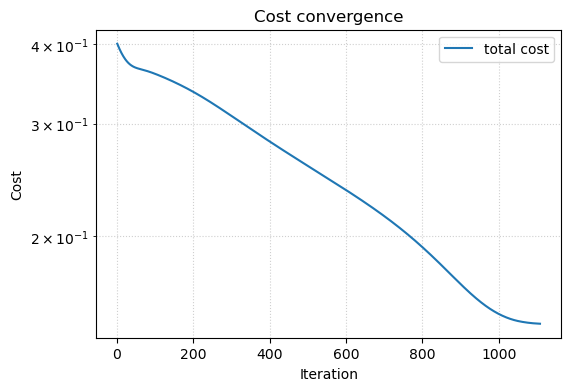

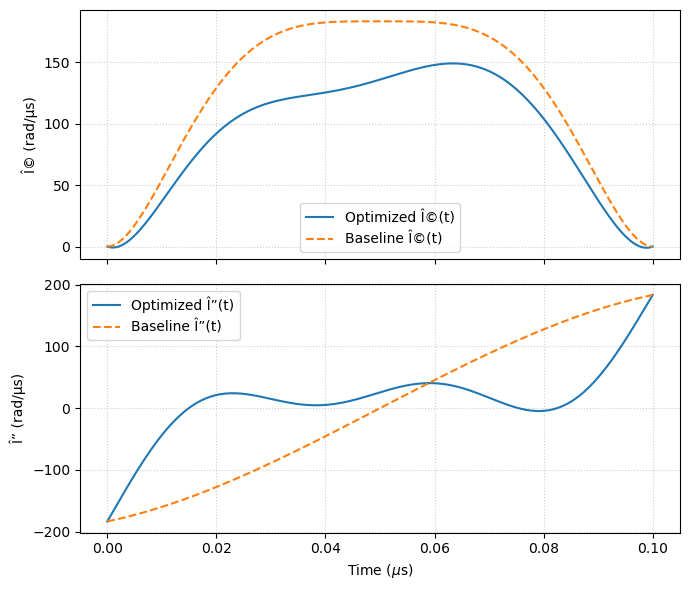

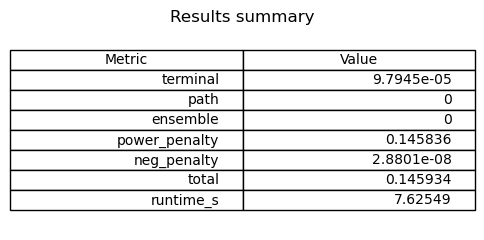

In [11]:
# @title Standard Plots
_ = plot_cost_history(result)
_ = plot_pulses(result)
_ = plot_summary(result)


## Penalty History


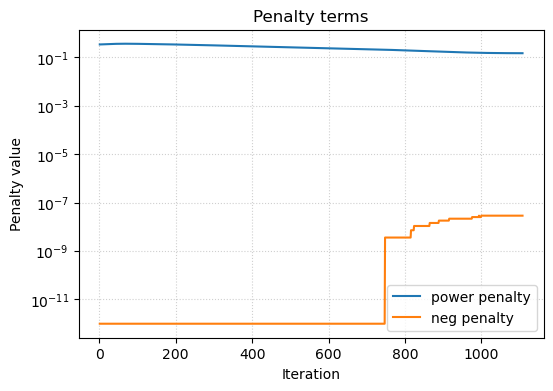

In [12]:
# @title Penalty History
_ = plot_penalties_history(result)


## Results Summary


In [13]:
# @title Results Summary
from pathlib import Path

metrics_table = {
    'terminal_infidelity': result.final_metrics.get('terminal'),
    'path_infidelity': result.final_metrics.get('path'),
    'ensemble_infidelity': result.final_metrics.get('ensemble'),
    'power_penalty': result.final_metrics.get('power_penalty'),
    'neg_penalty': result.final_metrics.get('neg_penalty'),
    'total_cost': result.final_metrics.get('total'),
    'runtime_seconds': result.final_metrics.get('runtime_s'),
}
print('Final metrics:')
for key, value in metrics_table.items():
    if value is not None:
        print(f"  {key:>20}: {value:.6g}")
    else:
        print(f"  {key:>20}: n/a")

print('\nArtifacts saved in', result.artifacts_dir)
for artifact in sorted(Path(result.artifacts_dir).iterdir()):
    print(' •', artifact.name)


Final metrics:
   terminal_infidelity: 9.7945e-05
       path_infidelity: 0
   ensemble_infidelity: 0
         power_penalty: 0.145836
           neg_penalty: 2.8801e-08
            total_cost: 0.145934
       runtime_seconds: 7.62549

Artifacts saved in C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\quickstart\adam-default-20250922-113937
 • config.json
 • figures
 • history.npz
 • logs.txt
 • metrics.json
 • pulses.npz


## Troubleshooting

- Learning rate too aggressive? Decrease `learning_rate` (Adam/const) or `alpha0` (line-search).
- Cost plateaus early? Raise `max_iters` or relax penalty weights.
- Armijo fails repeatedly? Tune `ls_beta` (0.3–0.7) and `ls_sigma` (1e-4–1e-2).
- Negativity penalty dominates? Reduce `w_neg` or increase `neg_kappa`.
- Basis too restrictive? Increase `K` or provide custom `omegas_rad_per_us`/`phases`.
- Detuning updates unstable? Set `use_delta` to `False` to keep the baseline detuning.
- Ensemble sweeps slow? Trim `num_beta` / `num_detuning` or enable `grad_clip`.
- Large artifacts folder? Change `output_dir` or reuse an existing `run_name`.
